In [1]:
import torch
from torch import nn
import sklearn
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
from sklearn.datasets import make_circles

# make 1000 samples
n_samples = 1000

# create circles
X, y = make_circles(n_samples,
                   noise=0.03,
                   random_state=42)

In [3]:
len(X), len(y)

(1000, 1000)

In [4]:
print(f"First 5 samples of X:\n {X[:5]}")
print(f"\nFirst 5 samples of y:\n {y[:5]}")

First 5 samples of X:
 [[ 0.75424625  0.23148074]
 [-0.75615888  0.15325888]
 [-0.81539193  0.17328203]
 [-0.39373073  0.69288277]
 [ 0.44220765 -0.89672343]]

First 5 samples of y:
 [1 1 1 1 0]


In [5]:
# Make DataFrame of circle data
circles = pd.DataFrame({"X1": X[:, 0],
                        "X2": X[:, 1],
                       "label": y})
circles.head(10)

,X1,X2,label
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0
5,-0.479646,0.676435,1
6,-0.013648,0.803349,1
7,0.771513,0.147760,1
8,-0.169322,-0.793456,1
9,-0.121486,1.021509,0


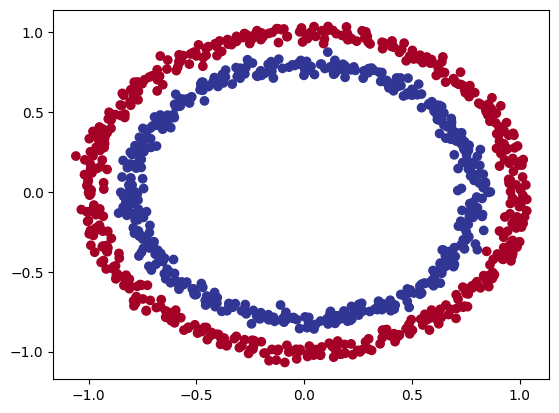

In [6]:
# Visualize
plt.scatter(x=X[:, 0],
           y=X[:, 1],
           c=y,
           cmap=plt.cm.RdYlBu)

# 1.1 Check input and output shapes

In [7]:
X.shape, y.shape

((1000, 2), (1000,))

In [8]:
# View the first example of features and labels

X_sample = X[0]
y_sample = y[0]

print(f"Values for one sample of X: {X_sample} and the same for y: {y_sample}")
print(f"shapess for one sample of X: {X_sample.shape} and the same for y: {y_sample.shape}")

Values for one sample of X: [0.75424625 0.23148074] and the same for y: 1
shapess for one sample of X: (2,) and the same for y: ()


# 1.2 Turn data into tensors and create train and test splits

In [9]:
type(X), X.dtype

(numpy.ndarray, dtype('float64'))

In [10]:
# Turn data into tensors
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

In [11]:
type(X), type(y)

(torch.Tensor, torch.Tensor)

In [12]:
X.dtype, y.dtype

(torch.float32, torch.float32)

In [13]:
# Split data into training and test sets
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,
                                                   y,
                                                   test_size=0.2, # 20% of the data
                                                   random_state=42)

In [14]:
len(X_train), len(X_test), len(y_train), len(y_test)

(800, 200, 800, 200)

## 2. Building a model

In [15]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [16]:
# 1. Construct a model that subclasses nn.Module

class CircleModel_V0(nn.Module):
    def __init__(self):
        super().__init__()
        # Create 2 nn.Linear layers capable of handling the shapes of our data
        self.layer_1 = nn.Linear(in_features=2, out_features=5)
        self.layer_2 = nn.Linear(in_features=5, out_features=1)

    # Define a forward() method that outlines the forward pass
    def forward(self, x):
        return self.layer_2(self.layer_1(x)) # x --> layer_1 --> layer_2 --> output

# Instantiate an instance of our model class and send it to the target device
model_0 = CircleModel_V0().to(device)
model_0

CircleModel_V0(
  (layer_1): Linear(in_features=2, out_features=5, bias=True)
  (layer_2): Linear(in_features=5, out_features=1, bias=True)
)

In [17]:
next(model_0.parameters()).device

device(type='cuda', index=0)

## Replication of the model

In [18]:
# Let's replicate the model above using nn.Sequential()
model_0_rep = nn.Sequential(
    nn.Linear(in_features=2, out_features=5),
    nn.Linear(in_features=5, out_features=1)
).to(device)

model_0

CircleModel_V0(
  (layer_1): Linear(in_features=2, out_features=5, bias=True)
  (layer_2): Linear(in_features=5, out_features=1, bias=True)
)

In [19]:
model_0_rep.state_dict()

OrderedDict([('0.weight',
              tensor([[ 0.6781, -0.1490],
                      [-0.0966,  0.1196],
                      [-0.2836,  0.1670],
                      [ 0.6286, -0.6955],
                      [-0.0939,  0.2699]], device='cuda:0')),
             ('0.bias',
              tensor([ 0.6894,  0.6482, -0.1354,  0.4717,  0.3582], device='cuda:0')),
             ('1.weight',
              tensor([[-0.1059,  0.1423, -0.3725, -0.3394, -0.4032]], device='cuda:0')),
             ('1.bias', tensor([-0.4145], device='cuda:0'))])

In [20]:
# Make predictions
with torch.inference_mode():
    untrained_preds = model_0_rep(X_test.to(device))
print(f"Length of predictions: {len(untrained_preds)}, Shape: {untrained_preds.shape}")
print(f"Length of test samples: {len(X_test)}, shape: {X_test.shape}")
print(f"\nFirst 10 predictions: \n{torch.round(untrained_preds[:10])}")
print(f"\nFirst 10 labels:\n{y_test[:10]}")

Length of predictions: 200, Shape: torch.Size([200, 1])
Length of test samples: 200, shape: torch.Size([200, 2])

First 10 predictions: 
tensor([[-1.],
        [-1.],
        [-1.],
        [-1.],
        [-1.],
        [-1.],
        [-1.],
        [-1.],
        [-1.],
        [-1.]], device='cuda:0')

First 10 labels:
tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.])


## 2.1 Setup loss function and optmizer

In [21]:
# Setup the loss function
# loss_fn = nn.BCELoss() #BCELoss = requires inputs to have gone through the sigmoid activation function prior to input to BCELoss
loss_fn = nn.BCEWithLogitsLoss() # == Sigmoid activation function built-in

# Setup the optimizer
optimizer = torch.optim.SGD(params=model_0_rep.parameters(),
                           lr=0.1)

In [22]:
# Calculate accuracy

def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct/len(y_pred)) * 100
    return acc

## 3. Train Model

To train our model, we're goint to need to build a training loop:

1. Forward pass
2. Calculate the loss
3. Optimzer zero grad
4. Loss backward (backpropagation)
5. Optimizer step (gradient descent)

### 3.1 Going from raw logits -> prediction probilities -> prediction labels

our model outputs are going to be raw **logits**.

We can convert these **logits** into **prediction probabilities** by passing them to some kind of activation function (e.g. sigmoid for binary classification and softmax for multiclass classification).

Then we can convert our model's prediction probabilities to **prediction labels** by either rounding them or taking the `argmax()`.

In [23]:
# View the first 5 outputs of the forward pass on the test data
model_0.eval()
with torch.inference_mode():
    y_logits = model_0_rep(X_test.to(device))[:5]
y_logits

tensor([[-0.5242],
        [-0.5578],
        [-0.5709],
        [-0.5105],
        [-0.7845]], device='cuda:0')

In [24]:
y_test[:5]

tensor([1., 0., 1., 0., 1.])

In [25]:
# Use the sigmoid activation function on our model logits to turn them into prediction probabilities
y_pred_probs = torch.sigmoid(y_logits)
y_pred_probs

tensor([[0.3719],
        [0.3641],
        [0.3610],
        [0.3751],
        [0.3133]], device='cuda:0')

In [26]:
torch.round(y_pred_probs)

tensor([[0.],
        [0.],
        [0.],
        [0.],
        [0.]], device='cuda:0')

For our prediction probability values, we need to perform a range-style rounding on them:
* `y_pred_probs >= 0.5, y = 1` (class 1)
* `y_pred_probs < 0.5, y = 0` (class 0)

In [27]:
# Find the predicted labels
y_preds = torch.round(y_pred_probs)

# In full ( logits -> pred probs -> pred labels)
y_pred_labels = torch.round(torch.sigmoid(model_0_rep(X_test.to(device))[:5]))

# Check for equality
print(torch.eq(y_preds.squeeze(), y_pred_labels.squeeze()))

# Get rid of extra dimension
y_preds.squeeze()

tensor([True, True, True, True, True], device='cuda:0')


tensor([0., 0., 0., 0., 0.], device='cuda:0')

In [28]:
y_preds[:5]

tensor([[0.],
        [0.],
        [0.],
        [0.],
        [0.]], device='cuda:0')

In [29]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Set the number of epochs
epochs = 100

# Put data to target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

# Build training and evaluation loop
for epoch in range(epochs):
    ### Training
    model_0_rep.train()

    # 1. Forward pass
    y_logits = model_0_rep(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits)) # Turn logits -> pred probs -> pred labels

    # 2. Calculate loss/accuracy
    # loss = loss_fn(torch.sigmoiad(y_logits), # nn.BCELoss expects prediction probabilities
                  # y_train)
    loss = loss_fn(y_logits, # nn.BCEWithLogitsLoss expects raw logits as input
                 y_train)
    acc = accuracy_fn(y_true=y_train, y_pred=y_pred)

    # 3. Optimize zero grad
    optimizer.zero_grad()

    # 4. Loss Backward
    loss.backward()

    # 5. Optimizer set (gradient descent)
    optimizer.step()

    ### Testing
    model_0_rep.eval()
    with torch.inference_mode():
        # 1. Forward pass
        test_logits = model_0_rep(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))

        # 3. Calculate test loss/acc
        test_loss = loss_fn(test_logits,
                            y_test)
        test_acc = accuracy_fn(y_true=y_test,
                               y_pred=test_pred)

    # Print out what's happenin'
    if epoch % 10 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Acc: {acc:.2f}% | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%")
        

Epoch: 0 | Loss: 0.74658, Acc: 50.00% | Test loss: 0.73922, Test acc: 50.00%
Epoch: 10 | Loss: 0.70634, Acc: 50.00% | Test loss: 0.70503, Test acc: 50.00%
Epoch: 20 | Loss: 0.69629, Acc: 50.00% | Test loss: 0.69661, Test acc: 50.00%
Epoch: 30 | Loss: 0.69383, Acc: 50.00% | Test loss: 0.69462, Test acc: 50.00%
Epoch: 40 | Loss: 0.69323, Acc: 50.00% | Test loss: 0.69420, Test acc: 50.00%
Epoch: 50 | Loss: 0.69307, Acc: 47.25% | Test loss: 0.69414, Test acc: 48.50%
Epoch: 60 | Loss: 0.69303, Acc: 49.62% | Test loss: 0.69416, Test acc: 47.50%
Epoch: 70 | Loss: 0.69301, Acc: 50.12% | Test loss: 0.69419, Test acc: 47.00%
Epoch: 80 | Loss: 0.69300, Acc: 50.38% | Test loss: 0.69423, Test acc: 47.00%
Epoch: 90 | Loss: 0.69300, Acc: 50.75% | Test loss: 0.69427, Test acc: 47.00%


## 4. Make predictions and evaluate the model

From the metrics it looks like our model isn't learning anything....

So to inspect it let's make some predictions and make them visual!

In other words, " Visualize, Visualize Visualize!"

In [30]:
import requests
from pathlib import Path

# Download helper functions from learn PyTOrch repo (If it's not already downloaded)
if Path("helper_functions.py").is_file():
    print("helper_functions.py already exists, skipping download")
else:
    print("Downloading helper_functions.py")
    request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
    with open("helper_functions.py", "wb") as f:
        f.write(request.content)

helper_functions.py already exists, skipping download


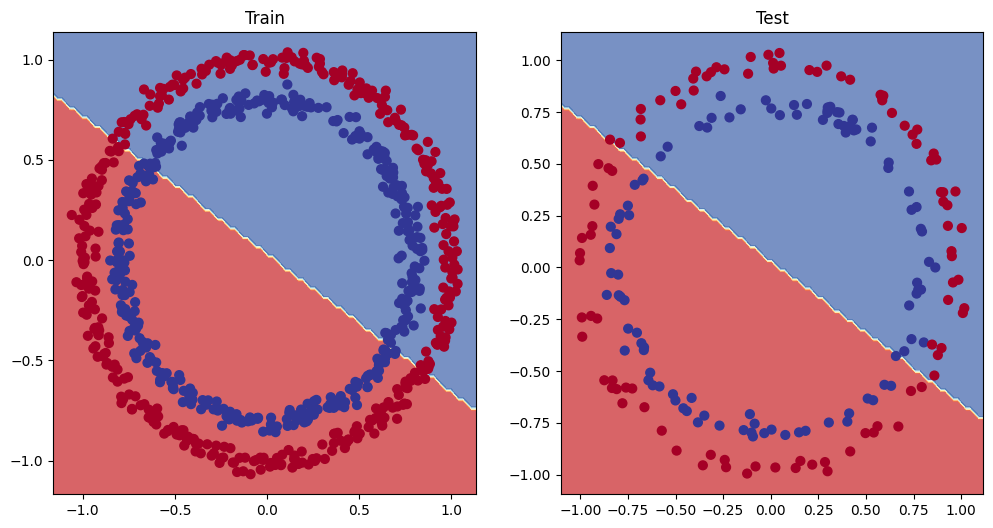

In [31]:
from helper_functions import plot_predictions, plot_decision_boundary

# Plot decision boundary of the model
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train") 
plot_decision_boundary(model_0_rep, X_train, y_train)
plt.subplot(1, 2, 2)

plt.title("Test")
plot_decision_boundary(model_0_rep, X_test, y_test)



## 5. Improving a model (from a model perspective)

*  Add more layers - give the model more chances to learn about patterns in the data
*  Add more hidden units - go from 5 hidden units to 10 hidden units
*  Fit for longer
*  Changing the activation functions
*  Change the learning rate
*  Change the loss function

These options are all from a model's perspective because they deal directly with the model, rather thna the data.

And because these options are all values we (as machine learning engineers and data scientists) can change, they are referred as hyperparameters.

In [32]:
model_0_rep.state_dict()

OrderedDict([('0.weight',
              tensor([[ 0.6772, -0.1476],
                      [-0.0937,  0.1240],
                      [-0.2898,  0.1613],
                      [ 0.6238, -0.6982],
                      [-0.1001,  0.2658]])),
             ('0.bias', tensor([ 0.6849,  0.7006, -0.2305,  0.4047,  0.2700])),
             ('1.weight',
              tensor([[ 0.0674,  0.3037, -0.4183, -0.2335, -0.3256]])),
             ('1.bias', tensor([-0.1740]))])

In [33]:
class CircleModelV1(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(in_features=2, out_features=10)
        self.layer_2 = nn.Linear(in_features=10, out_features=10)
        self.layer_3 = nn.Linear(in_features=10, out_features=1)

    def forward(self, x):
        # z = self.layer_1(x)
        # z = self.layer_2(x)
        # z = self.layer_3(x)
        return self.layer_3(self.layer_2(self.layer_1(x))) # this way of writing operations brings more speedups wherever possible

model_1 = CircleModelV1().to(device)
model_1

CircleModelV1(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
)

In [34]:
# create a loss function

loss_fn = nn.BCEWithLogitsLoss()

# Create an optimizer
optimizer = torch.optim.SGD(params=model_1.parameters(),
                           lr=0.1)

In [35]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Set the number of epochs
epochs = 1000

# Put data to target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

# Build training and evaluation loop
for epoch in range(epochs):
    ### Training
    model_1.train()

    # 1. Forward pass
    y_logits = model_1(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits)) # Turn logits -> pred probs -> pred labels

    # 2. Calculate loss/accuracy
    # loss = loss_fn(torch.sigmoiad(y_logits), # nn.BCELoss expects prediction probabilities
                  # y_train)
    loss = loss_fn(y_logits, # nn.BCEWithLogitsLoss expects raw logits as input
                 y_train)
    acc = accuracy_fn(y_true=y_train, y_pred=y_pred)

    # 3. Optimize zero grad
    optimizer.zero_grad()

    # 4. Loss Backward
    loss.backward()

    # 5. Optimizer set (gradient descent)
    optimizer.step()

    ### Testing
    model_1.eval()
    with torch.inference_mode():
        # 1. Forward pass
        test_logits = model_1(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))

        # 3. Calculate test loss/acc
        test_loss = loss_fn(test_logits,
                            y_test)
        test_acc = accuracy_fn(y_true=y_test,
                               y_pred=test_pred)

    # Print out what's happenin'
    if epoch % 100 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Acc: {acc:.2f}% | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%")
        

Epoch: 0 | Loss: 0.69396, Acc: 50.88% | Test loss: 0.69261, Test acc: 51.00%
Epoch: 100 | Loss: 0.69305, Acc: 50.38% | Test loss: 0.69379, Test acc: 48.00%
Epoch: 200 | Loss: 0.69299, Acc: 51.12% | Test loss: 0.69437, Test acc: 46.00%
Epoch: 300 | Loss: 0.69298, Acc: 51.62% | Test loss: 0.69458, Test acc: 45.00%
Epoch: 400 | Loss: 0.69298, Acc: 51.12% | Test loss: 0.69465, Test acc: 46.00%
Epoch: 500 | Loss: 0.69298, Acc: 51.00% | Test loss: 0.69467, Test acc: 46.00%
Epoch: 600 | Loss: 0.69298, Acc: 51.00% | Test loss: 0.69468, Test acc: 46.00%
Epoch: 700 | Loss: 0.69298, Acc: 51.00% | Test loss: 0.69468, Test acc: 46.00%
Epoch: 800 | Loss: 0.69298, Acc: 51.00% | Test loss: 0.69468, Test acc: 46.00%
Epoch: 900 | Loss: 0.69298, Acc: 51.00% | Test loss: 0.69468, Test acc: 46.00%


## Plot the decision boundary

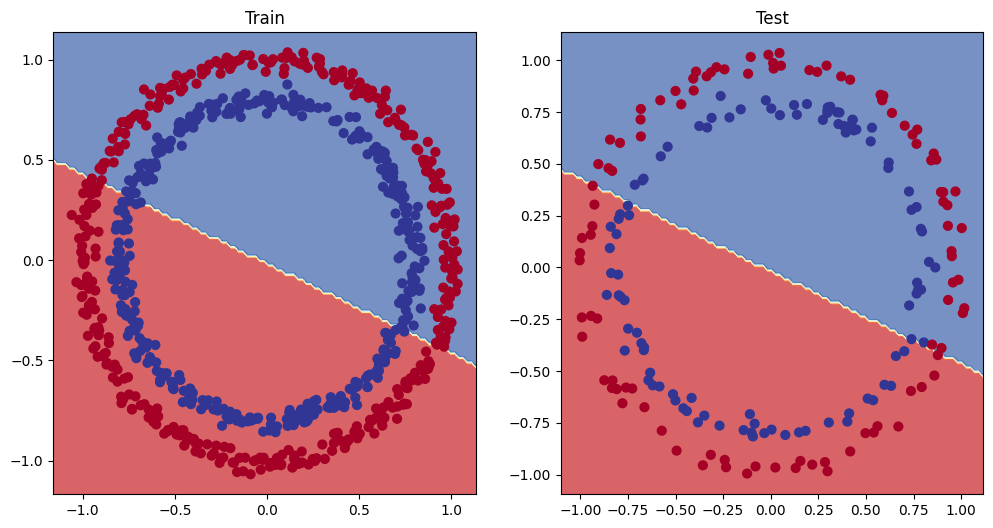

In [36]:
from helper_functions import plot_predictions, plot_decision_boundary

# Plot decision boundary of the model
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train") 
plot_decision_boundary(model_1, X_train, y_train)
plt.subplot(1, 2, 2)

plt.title("Test")
plot_decision_boundary(model_1, X_test, y_test)

In [37]:
# create some data (same as notebook 01)

weight = 0.7
bias = 0.3
start = 0
end = 1
step = 0.01

# Create data 
X_regression = torch.arange(start, end, step).unsqueeze(dim=1)
y_regression = weight * X_regression + bias # Linear regression formula (without epsilon)

# Check the data
print(len(X_regression))
X_regression[:5], y_regression[:5]

100


(tensor([[0.0000],
         [0.0100],
         [0.0200],
         [0.0300],
         [0.0400]]),
 tensor([[0.3000],
         [0.3070],
         [0.3140],
         [0.3210],
         [0.3280]]))

In [38]:
# Create train and test splits
train_split = int(0.8 * len(X_regression))

X_train_regression, y_train_regression = X_regression[:train_split], y_regression[:train_split]
X_test_regression, y_test_regression = X_regression[train_split:], y_regression[train_split:]

len(X_train_regression), len(X_test_regression), len(y_train_regression), len(y_test_regression)

(80, 20, 80, 20)

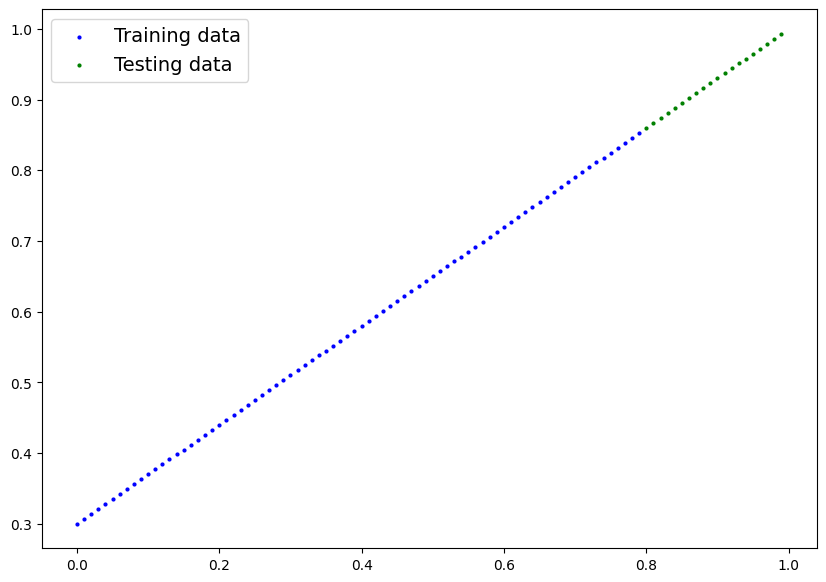

In [39]:
plot_predictions(train_data=X_train_regression,
                train_labels=y_train_regression,
                test_data=X_test_regression,
                test_labels=y_test_regression)

### 5.2 Adjusting `model_1` to fit a straight line

In [40]:
# Same architechture as model_1 (but using nn.Sequential())
model_2 = nn.Sequential(
    nn.Linear(in_features=1, out_features=10),
    nn.Linear(in_features=10, out_features=10),
    nn.Linear(in_features=10, out_features=1)
)

model_2.to(device)
model_2

Sequential(
  (0): Linear(in_features=1, out_features=10, bias=True)
  (1): Linear(in_features=10, out_features=10, bias=True)
  (2): Linear(in_features=10, out_features=1, bias=True)
)

In [41]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [42]:
# Loss and optimizer
loss_fn = nn.L1Loss()
optimizer = torch.optim.SGD(params=model_2.parameters(),
                           lr=0.001)

In [43]:
# Train the model
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Set the number of epochs
epochs = 1000

# Put data to target device
X_train_regression, y_train_regression = X_train_regression.to(device), y_train_regression.to(device)
X_test_regression, y_test_regression = X_test_regression.to(device), y_test_regression.to(device)

# Build training and evaluation loop
for epoch in range(epochs):
    y_pred = model_2(X_train_regression)
    loss = loss_fn(y_pred, y_train_regression)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # testing
    model_2.eval()
    with torch.inference_mode():
        # 1. Forward pass
        test_pred = model_2(X_test_regression)
        test_loss = loss_fn(test_pred, y_test_regression)

    # Print out what's happenin'
    if epoch % 100 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Test loss: {test_loss:.5f}")


Epoch: 0 | Loss: 0.75986, Test loss: 0.94965
Epoch: 100 | Loss: 0.40272, Test loss: 0.54029
Epoch: 200 | Loss: 0.05876, Test loss: 0.13480
Epoch: 300 | Loss: 0.01461, Test loss: 0.03342
Epoch: 400 | Loss: 0.00308, Test loss: 0.00008
Epoch: 500 | Loss: 0.00309, Test loss: 0.00012
Epoch: 600 | Loss: 0.00309, Test loss: 0.00018
Epoch: 700 | Loss: 0.00299, Test loss: 0.00011
Epoch: 800 | Loss: 0.00299, Test loss: 0.00016
Epoch: 900 | Loss: 0.00289, Test loss: 0.00011


In [44]:
model_2.state_dict()

OrderedDict([('0.weight',
              tensor([[ 0.7609],
                      [ 0.8403],
                      [-0.2573],
                      [ 0.9280],
                      [-0.2226],
                      [ 0.2193],
                      [-0.5086],
                      [ 0.6019],
                      [ 0.8927],
                      [-0.7369]], device='cuda:0')),
             ('0.bias',
              tensor([ 0.8559,  0.2020,  0.6969,  0.1487,  0.4760, -0.1123,  0.7332,  0.1682,
                      -0.4494,  0.2490], device='cuda:0')),
             ('1.weight',
              tensor([[-0.0830, -0.0047, -0.1005,  0.2421, -0.2326, -0.1462, -0.0666, -0.1662,
                        0.0322, -0.3205],
                      [ 0.3219, -0.2488,  0.2589,  0.0726, -0.0938,  0.1958,  0.0606,  0.2701,
                        0.0379, -0.1059],
                      [ 0.0260, -0.1159,  0.1063,  0.2524,  0.1663, -0.1377,  0.1605,  0.0343,
                        0.1592, -0.1857],
         

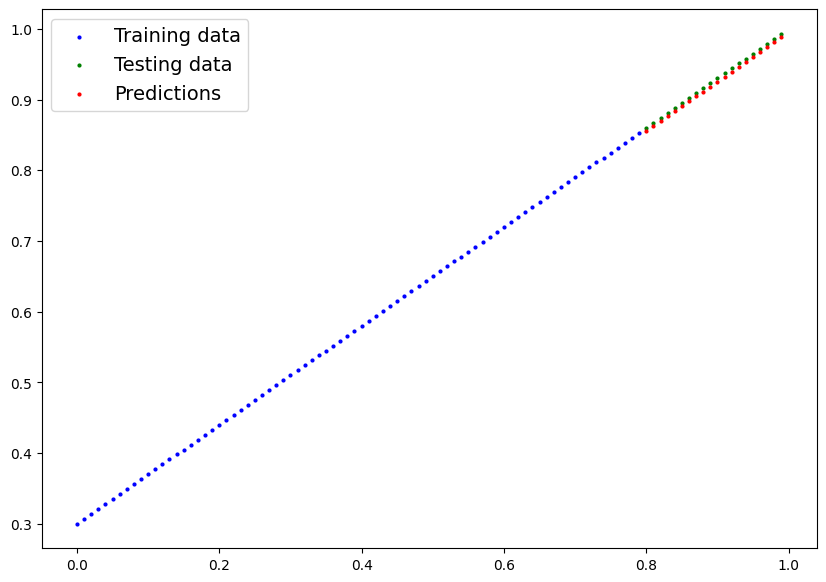

In [45]:
# Turn on evaluation mode
model_2.eval()

# Make predictions (inference)
with torch.inference_mode():
    y_preds = model_2(X_test_regression)

# Plot data and predictions
plot_predictions(train_data=X_train_regression.cpu(),
                train_labels=y_train_regression.cpu(),
                test_data=X_test_regression.cpu(),
                test_labels=y_test_regression.cpu(),
                predictions=y_preds.cpu())


# The missing piece: non-linearity
" What patterns could you draw if you were given an infinite amount of straight and non-straight lines?"

Or in machine learning terms, an infinite (but really it is finite) of linear and non-linear functions?

# 6.1 Recreating non-linear data (red and blue circles)

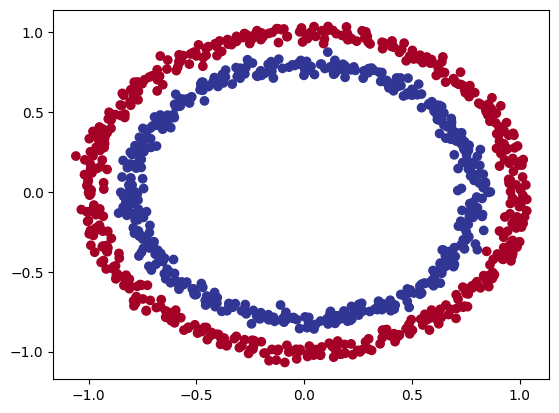

In [46]:
# Make and plot
import matplotlib.pyplot as plt
from sklearn.datasets import make_circles

n_samples = 1000

# create circles
X, y = make_circles(n_samples,
                   noise=0.03,
                   random_state=42)
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.RdYlBu);

In [47]:
import torch
from sklearn.model_selection import train_test_split

# Turn data into tensors
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

X_train, X_test, y_train, y_test = train_test_split(X,
                                                   y,
                                                   test_size=0.2, # 20% of the data
                                                   random_state=42)

In [48]:
len(X_train), len(X_test), len(y_train), len(X_test), y_test[:5]

(800, 200, 800, 200, tensor([1., 0., 1., 0., 1.]))

In [49]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [50]:
# Build a model with non-linear activation functions
from torch import nn
class CircleModelV2(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(in_features=2, out_features=10)
        self.layer_2 = nn.Linear(in_features=10, out_features=10)
        self.layer_3 = nn.Linear(in_features=10, out_features=1)
        self.relu = nn.ReLU()

    def forward(self, x):
        return self.layer_3(self.relu(self.layer_2(self.relu(self.layer_1(x)))))

model_3 = CircleModelV2().to(device)
model_3

CircleModelV2(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
  (relu): ReLU()
)

In [51]:
# Calculate accuracy

def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct/len(y_pred)) * 100
    return acc

In [52]:
loss_fn = nn.BCEWithLogitsLoss() # == Sigmoid activation function built-in

# Setup the optimizer
optimizer = torch.optim.SGD(params=model_3.parameters(),
                           lr=0.1)

In [53]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Set the number of epochs
epochs = 1500

# Put data to target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

# Build training and evaluation loop
for epoch in range(epochs):
    ### Training
    model_3.train()

    # 1. Forward pass
    y_logits = model_3(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits)) # Turn logits -> pred probs -> pred labels

    # 2. Calculate loss/accuracy
    # loss = loss_fn(torch.sigmoiad(y_logits), # nn.BCELoss expects prediction probabilities
                  # y_train)
    loss = loss_fn(y_logits, # nn.BCEWithLogitsLoss expects raw logits as input
                 y_train)
    acc = accuracy_fn(y_true=y_train, y_pred=y_pred)

    # 3. Optimize zero grad
    optimizer.zero_grad()

    # 4. Loss Backward
    loss.backward()

    # 5. Optimizer set (gradient descent)
    optimizer.step()

    ### Testing
    model_3.eval()
    with torch.inference_mode():
        # 1. Forward pass
        test_logits = model_3(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))

        # 3. Calculate test loss/acc
        test_loss = loss_fn(test_logits,
                            y_test)
        test_acc = accuracy_fn(y_true=y_test,
                               y_pred=test_pred)

    # Print out what's happenin'
    if epoch % 100 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Acc: {acc:.2f}% | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%")
print(f"Epoch: {epoch} | Loss: {loss:.5f}, Acc: {acc:.2f}% | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%")

Epoch: 0 | Loss: 0.69295, Acc: 50.00% | Test loss: 0.69319, Test acc: 50.00%
Epoch: 100 | Loss: 0.69115, Acc: 52.88% | Test loss: 0.69102, Test acc: 52.50%
Epoch: 200 | Loss: 0.68977, Acc: 53.37% | Test loss: 0.68940, Test acc: 55.00%
Epoch: 300 | Loss: 0.68795, Acc: 53.00% | Test loss: 0.68723, Test acc: 56.00%
Epoch: 400 | Loss: 0.68517, Acc: 52.75% | Test loss: 0.68411, Test acc: 56.50%
Epoch: 500 | Loss: 0.68102, Acc: 52.75% | Test loss: 0.67941, Test acc: 56.50%
Epoch: 600 | Loss: 0.67515, Acc: 54.50% | Test loss: 0.67285, Test acc: 56.00%
Epoch: 700 | Loss: 0.66659, Acc: 58.38% | Test loss: 0.66322, Test acc: 59.00%
Epoch: 800 | Loss: 0.65160, Acc: 64.00% | Test loss: 0.64757, Test acc: 67.50%
Epoch: 900 | Loss: 0.62362, Acc: 74.00% | Test loss: 0.62145, Test acc: 79.00%
Epoch: 1000 | Loss: 0.56818, Acc: 87.75% | Test loss: 0.57378, Test acc: 86.50%
Epoch: 1100 | Loss: 0.48153, Acc: 93.50% | Test loss: 0.49935, Test acc: 90.50%
Epoch: 1200 | Loss: 0.37056, Acc: 97.75% | Test loss

In [54]:
# Make predictions
model_3.eval()
with torch.inference_mode():
    y_preds = torch.round(torch.sigmoid(model_3(X_test))).squeeze()
y_preds[:10], y_test[:10]

(tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.], device='cuda:0'),
 tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.], device='cuda:0'))

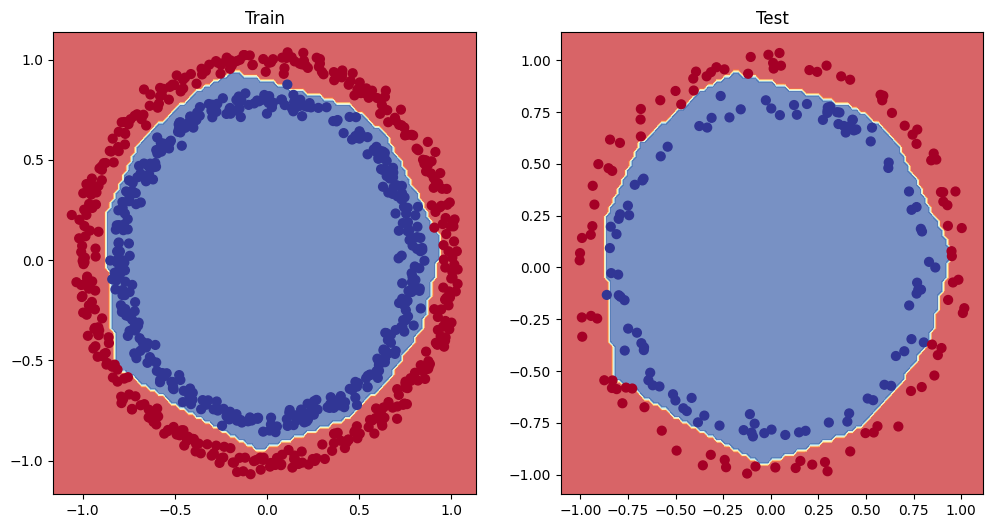

In [55]:
from helper_functions import plot_predictions, plot_decision_boundary

# Plot decision boundary of the model
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train") 
plot_decision_boundary(model_3, X_train, y_train)
plt.subplot(1, 2, 2)

plt.title("Test")
plot_decision_boundary(model_3, X_test, y_test)

# 7. Replicating non-linear activation functions

Neural networks, rather than us telling the model what to learn, we give it the tools to discover patterns in data and it tries to figure out the patterns on its own.

And these tools are linear & non-linear functions


In [56]:
# Create a tensor
A = torch.arange(-10, 10, 1, dtype=torch.float32)

A.dtype

torch.float32

In [57]:
A

tensor([-10.,  -9.,  -8.,  -7.,  -6.,  -5.,  -4.,  -3.,  -2.,  -1.,   0.,   1.,
          2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.])

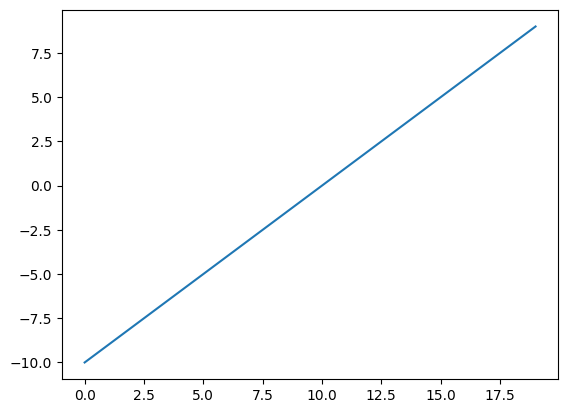

In [58]:
# Visualize the tensor
plt.plot(A);

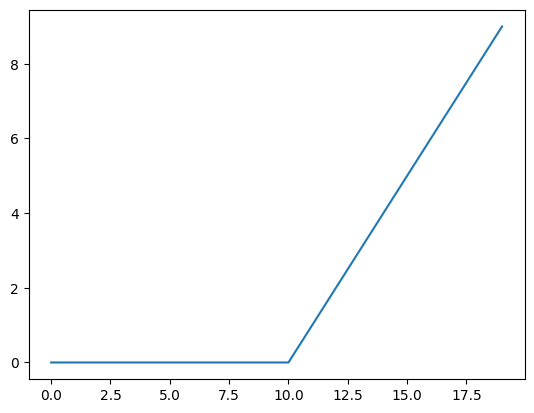

In [59]:
plt.plot(torch.relu(A));

In [60]:
def relu(x: torch.Tensor) -> torch.Tensor:
    return torch.maximum(torch.tensor(0), x) # inputs must be tensors
relu(A)

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 2., 3., 4., 5., 6., 7.,
        8., 9.])

In [61]:
def sigmoid(x):
    return 1 / (1 + torch.exp(-x))
sigmoid(A)

tensor([4.5398e-05, 1.2339e-04, 3.3535e-04, 9.1105e-04, 2.4726e-03, 6.6929e-03,
        1.7986e-02, 4.7426e-02, 1.1920e-01, 2.6894e-01, 5.0000e-01, 7.3106e-01,
        8.8080e-01, 9.5257e-01, 9.8201e-01, 9.9331e-01, 9.9753e-01, 9.9909e-01,
        9.9966e-01, 9.9988e-01])

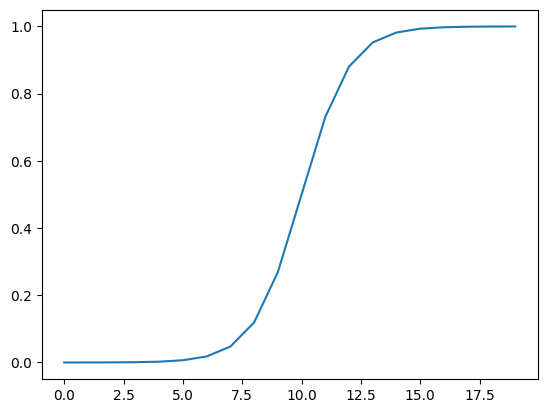

In [62]:
plt.plot(torch.sigmoid(A))

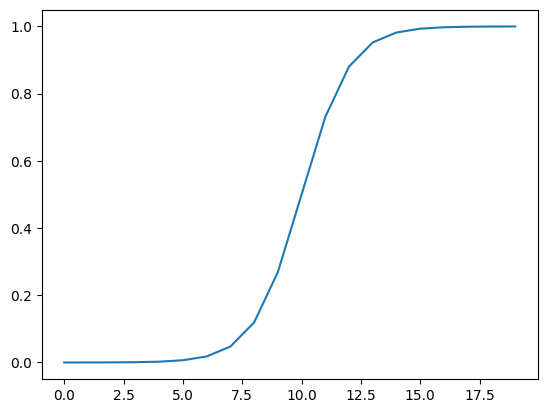

In [63]:
plt.plot(sigmoid(A))

# Multi-class classification

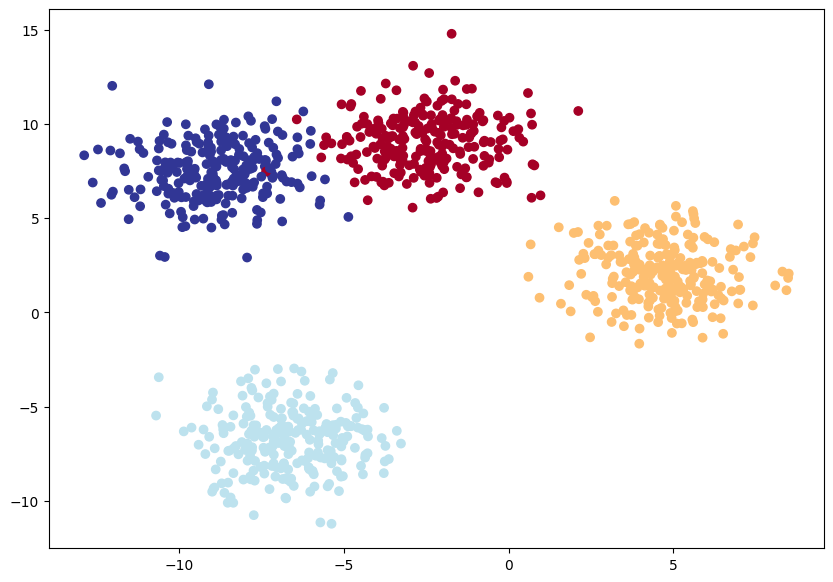

In [64]:
import torch 
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split

# Set the HYPERPARAMETERS or data creation
NUM_CLASSES = 4
NUM_FEATURES = 2
RANDOM_SEED = 42

# 1. Create multi-class data
X_blob, y_blob = make_blobs(n_samples=1000,
                           n_features=NUM_FEATURES,
                           centers=NUM_CLASSES,
                           cluster_std=1.5,
                           random_state=RANDOM_SEED)

# 2. Turn data into tensors
X_blob = torch.from_numpy(X_blob).type(torch.float)
y_blob = torch.from_numpy(y_blob).type(torch.LongTensor)

#. Split into train and test
X_blob_train, X_blob_test, y_blob_train, y_blob_test = train_test_split(X_blob,
                                                                       y_blob,
                                                                       test_size=0.2,
                                                                       random_state=RANDOM_SEED)

# 4. PLOT data (Visualize, Visualize, Visualize)
plt.figure(figsize=(10, 7))
plt.scatter(X_blob[:, 0], X_blob[:, 1], c=y_blob, cmap=plt.cm.RdYlBu)


In [65]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [66]:
class BlobModel(nn.Module):
    def __init__(self, input_features, output_features, hidden_units=8):
        """ Initializes multi-class classification model.
        
        Args:
            input_features (int): Number of input features to the model
            output_features (int): Number of outputs features (number of output classes)
            hidden_units (int): Number of hidden units between layers, default 8

        Returns:
            ...
        """
        super().__init__()
        self.linear_layer_stack = nn.Sequential(
            nn.Linear(in_features=input_features, out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features=output_features)
        )
    def forward(self, x):
        return self.linear_layer_stack(x)

model_4 = BlobModel(input_features=2,
                   output_features=4,
                   hidden_units=8).to(device)
model_4

BlobModel(
  (linear_layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): ReLU()
    (2): Linear(in_features=8, out_features=8, bias=True)
    (3): ReLU()
    (4): Linear(in_features=8, out_features=4, bias=True)
  )
)

In [67]:
## Loss functions and an optimizer | loss function measures how wrong our model's predictions are
loss_fn = nn.CrossEntropyLoss()

# optimizer --> updates our model parameters to try and reduce the loss
optimizer = torch.optim.SGD(params=model_4.parameters(),
                           lr=0.01,)

In [68]:
## checking model parameters on which device (cpu or gpu)
next(model_4.parameters()).device

device(type='cuda', index=0)

In [69]:
## checking on which device (cpu or gpu) our test data is 
X_blob_test.device

device(type='cpu')

### 8.4 Getting prediction probabilities for a multi-class PyTorch model

In order to evaluate and train and test our model, we need to convert our model's outputs (logits) to prediction probabilities and then to prediction labels.

Logits (raw output of the model) --> Pred probabilities (use `torch.softmax') --> Pred labels ( take the argmax the prediciton probabilities)

( How do we do this? :: using activation functions)

In [70]:
# Let's get some raw outputs of our model (logits)
model_4.eval()
with torch.inference_mode():
    y_logits = model_4(X_blob_test.to(device))

y_logits[:10]

tensor([[-0.7646, -0.7412, -1.5777, -1.1376],
        [-0.0973, -0.9431, -0.5963, -0.1371],
        [ 0.2528, -0.2379,  0.1882, -0.0066],
        [-0.4134, -0.5204, -0.9303, -0.6963],
        [-0.3118, -1.3736, -1.1991, -0.3834],
        [-0.1497, -1.0617, -0.7107, -0.1645],
        [ 0.1539, -0.2887,  0.1520, -0.0109],
        [-0.2154, -1.1795, -0.9300, -0.2745],
        [ 0.2443, -0.2472,  0.1649,  0.0061],
        [-0.2329, -1.2120, -0.9849, -0.3004]], device='cuda:0')

In [71]:
y_blob_test[:10] # We want those values above in the format of the values below. 

tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0])

In [72]:
## Convert our model's logit outputs to prediction ptobabilities
y_pred_probs = torch.softmax(y_logits, dim=1)
print(y_logits[:5])
print(y_pred_probs[:5])

tensor([[-0.7646, -0.7412, -1.5777, -1.1376],
        [-0.0973, -0.9431, -0.5963, -0.1371],
        [ 0.2528, -0.2379,  0.1882, -0.0066],
        [-0.4134, -0.5204, -0.9303, -0.6963],
        [-0.3118, -1.3736, -1.1991, -0.3834]], device='cuda:0')
tensor([[0.3169, 0.3244, 0.1405, 0.2182],
        [0.3336, 0.1432, 0.2026, 0.3206],
        [0.3011, 0.1843, 0.2823, 0.2323],
        [0.3078, 0.2766, 0.1836, 0.2320],
        [0.3719, 0.1286, 0.1532, 0.3463]], device='cuda:0')


In [73]:
torch.sum(y_pred_probs[0])

tensor(1., device='cuda:0')

In [74]:
torch.max(y_pred_probs[0])

tensor(0.3244, device='cuda:0')

In [75]:
torch.argmax(y_pred_probs[0])

tensor(1, device='cuda:0')

In [76]:
## Convert our model's prediction probabilities to prediction labels
y_preds = torch.argmax(y_pred_probs, dim=1)
y_preds

tensor([1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 3, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
        1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 1, 0, 1, 0, 0, 0,
        0, 0, 0, 0, 3, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
        1, 0, 0, 0, 0, 1, 0, 1], device='cuda:0')

In [77]:
y_blob_test

tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0, 0, 1, 0, 0, 0, 3, 3, 2, 3, 3, 3, 0, 1, 2,
        2, 2, 3, 0, 1, 0, 3, 1, 1, 3, 1, 2, 1, 3, 0, 2, 0, 3, 3, 2, 0, 3, 1, 1,
        0, 3, 1, 0, 1, 1, 3, 2, 1, 1, 3, 2, 2, 0, 3, 2, 2, 0, 0, 3, 3, 0, 0, 3,
        3, 3, 2, 3, 3, 3, 3, 1, 0, 2, 3, 2, 3, 3, 2, 3, 3, 2, 3, 3, 1, 3, 3, 3,
        1, 0, 3, 2, 0, 0, 3, 0, 2, 3, 1, 0, 3, 2, 1, 1, 0, 2, 2, 3, 0, 0, 1, 2,
        2, 3, 0, 1, 2, 0, 0, 0, 2, 3, 1, 2, 3, 2, 0, 3, 0, 0, 1, 1, 1, 0, 2, 2,
        2, 2, 0, 3, 3, 2, 2, 1, 3, 2, 0, 0, 3, 3, 2, 1, 2, 0, 3, 2, 0, 3, 2, 0,
        2, 2, 2, 0, 3, 1, 1, 1, 1, 1, 3, 1, 0, 2, 2, 1, 2, 2, 0, 1, 2, 2, 0, 0,
        1, 3, 2, 0, 3, 1, 2, 1])

## 8.5 Create a traning and testing loop for a multi-class Pytorch model

In [78]:
# Calculate accuracy

def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct/len(y_pred)) * 100
    return acc

In [79]:
# Fit the multi-class model to the data
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Set number of epochs
epochs = 100

# Put the date to the target device
X_blob_train, y_blob_train = X_blob_train.to(device), y_blob_train.to(device)
X_blob_test, y_blob_test = X_blob_test.to(device), y_blob_test.to(device)

# Loop thorugh data
for epoch in range(epochs):
    ## Training
    model_4.train()

    y_logits = model_4(X_blob_train)
    y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)

    loss = loss_fn(y_logits, y_blob_train)
    acc = accuracy_fn(y_true=y_blob_train,
                     y_pred=y_pred)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    ### Testing
    model_4.eval()
    with torch.inference_mode():
        test_logits = model_4(X_blob_test)
        test_preds = torch.softmax(test_logits, dim=1).argmax(dim=1)

        test_loss = loss_fn(test_logits, y_blob_test)
        test_acc = accuracy_fn(y_blob_test,
                              y_pred=test_preds)

    ## Print what's happenin'
    if epoch % 10 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:4f}, Acc: {acc:.2f}% | Test loss: {test_loss:.4f}, Test acc: {test_acc:.2f}%")
print(f"Epoch: {epoch} | Loss: {loss:4f}, Acc: {acc:.2f}% | Test loss: {test_loss:.4f}, Test acc: {test_acc:.2f}%")

Epoch: 0 | Loss: 1.158826, Acc: 40.38% | Test loss: 1.1472, Test acc: 38.50%
Epoch: 10 | Loss: 1.064932, Acc: 55.38% | Test loss: 1.0684, Test acc: 50.50%
Epoch: 20 | Loss: 0.981897, Acc: 62.62% | Test loss: 0.9976, Test acc: 57.50%
Epoch: 30 | Loss: 0.911385, Acc: 70.50% | Test loss: 0.9360, Test acc: 67.00%
Epoch: 40 | Loss: 0.852853, Acc: 88.38% | Test loss: 0.8834, Test acc: 87.50%
Epoch: 50 | Loss: 0.804296, Acc: 92.12% | Test loss: 0.8385, Test acc: 93.00%
Epoch: 60 | Loss: 0.763501, Acc: 93.62% | Test loss: 0.7998, Test acc: 94.50%
Epoch: 70 | Loss: 0.728481, Acc: 94.88% | Test loss: 0.7659, Test acc: 95.00%
Epoch: 80 | Loss: 0.697687, Acc: 95.62% | Test loss: 0.7356, Test acc: 95.00%
Epoch: 90 | Loss: 0.669784, Acc: 96.38% | Test loss: 0.7076, Test acc: 96.50%
Epoch: 99 | Loss: 0.646354, Acc: 96.75% | Test loss: 0.6838, Test acc: 97.00%


In [80]:
# Make predictions
model_4.eval()
with torch.inference_mode():
    y_logits = model_4(X_blob_test)

# View the first 10 predictions
y_logits[:10]

tensor([[-1.5520,  1.7702, -3.0464, -2.5323],
        [-0.1348, -2.3305, -2.3721,  0.0972],
        [ 0.1727, -0.2462,  0.3317, -0.0312],
        [-0.9623,  1.3257, -1.6128, -1.5732],
        [ 0.0045, -2.1045, -3.4698, -0.7000],
        [-0.2060, -2.6914, -2.7822,  0.1333],
        [ 0.0815, -0.3303,  0.2308, -0.0381],
        [ 0.0133, -2.3748, -2.8843, -0.2998],
        [ 0.1518, -0.3270,  0.2987, -0.0882],
        [ 0.0534, -2.3575, -2.9727, -0.3954]], device='cuda:0')

In [81]:
# Go from logits to prediction probabilities
y_pred_probs = torch.softmax(y_logits, dim=1)
y_pred_probs[:10]

tensor([[0.0341, 0.9454, 0.0077, 0.0128],
        [0.4034, 0.0449, 0.0431, 0.5087],
        [0.2743, 0.1804, 0.3216, 0.2237],
        [0.0839, 0.8268, 0.0438, 0.0455],
        [0.6073, 0.0737, 0.0188, 0.3002],
        [0.3901, 0.0325, 0.0297, 0.5477],
        [0.2695, 0.1785, 0.3129, 0.2391],
        [0.5324, 0.0489, 0.0294, 0.3893],
        [0.2805, 0.1738, 0.3250, 0.2207],
        [0.5629, 0.0505, 0.0273, 0.3593]], device='cuda:0')

In [82]:
y_blob_test

tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0, 0, 1, 0, 0, 0, 3, 3, 2, 3, 3, 3, 0, 1, 2,
        2, 2, 3, 0, 1, 0, 3, 1, 1, 3, 1, 2, 1, 3, 0, 2, 0, 3, 3, 2, 0, 3, 1, 1,
        0, 3, 1, 0, 1, 1, 3, 2, 1, 1, 3, 2, 2, 0, 3, 2, 2, 0, 0, 3, 3, 0, 0, 3,
        3, 3, 2, 3, 3, 3, 3, 1, 0, 2, 3, 2, 3, 3, 2, 3, 3, 2, 3, 3, 1, 3, 3, 3,
        1, 0, 3, 2, 0, 0, 3, 0, 2, 3, 1, 0, 3, 2, 1, 1, 0, 2, 2, 3, 0, 0, 1, 2,
        2, 3, 0, 1, 2, 0, 0, 0, 2, 3, 1, 2, 3, 2, 0, 3, 0, 0, 1, 1, 1, 0, 2, 2,
        2, 2, 0, 3, 3, 2, 2, 1, 3, 2, 0, 0, 3, 3, 2, 1, 2, 0, 3, 2, 0, 3, 2, 0,
        2, 2, 2, 0, 3, 1, 1, 1, 1, 1, 3, 1, 0, 2, 2, 1, 2, 2, 0, 1, 2, 2, 0, 0,
        1, 3, 2, 0, 3, 1, 2, 1], device='cuda:0')

In [83]:
# Go from pred probs to pred labels
y_preds = torch.argmax(y_pred_probs, dim=1)

In [84]:
y_preds

tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0, 0, 1, 0, 0, 0, 3, 3, 2, 3, 3, 3, 0, 1, 2,
        2, 0, 3, 0, 1, 0, 3, 1, 1, 3, 1, 2, 1, 3, 0, 2, 0, 3, 3, 2, 0, 3, 1, 1,
        0, 3, 1, 0, 1, 1, 3, 2, 1, 1, 3, 2, 2, 0, 3, 2, 2, 0, 0, 3, 3, 0, 0, 3,
        3, 3, 2, 3, 3, 3, 3, 1, 0, 2, 3, 0, 3, 3, 2, 3, 3, 2, 3, 3, 1, 3, 3, 3,
        1, 0, 3, 2, 0, 0, 3, 0, 2, 3, 1, 0, 3, 2, 1, 1, 0, 2, 2, 3, 0, 0, 1, 0,
        2, 3, 0, 1, 2, 0, 0, 0, 2, 3, 1, 2, 3, 2, 0, 3, 0, 0, 1, 1, 1, 0, 2, 2,
        2, 0, 0, 3, 3, 0, 2, 1, 3, 0, 0, 0, 3, 3, 2, 1, 2, 0, 3, 2, 0, 3, 2, 0,
        2, 2, 2, 0, 3, 1, 1, 1, 1, 1, 3, 1, 0, 2, 2, 1, 2, 2, 0, 1, 2, 2, 0, 0,
        1, 3, 2, 0, 3, 1, 2, 1], device='cuda:0')

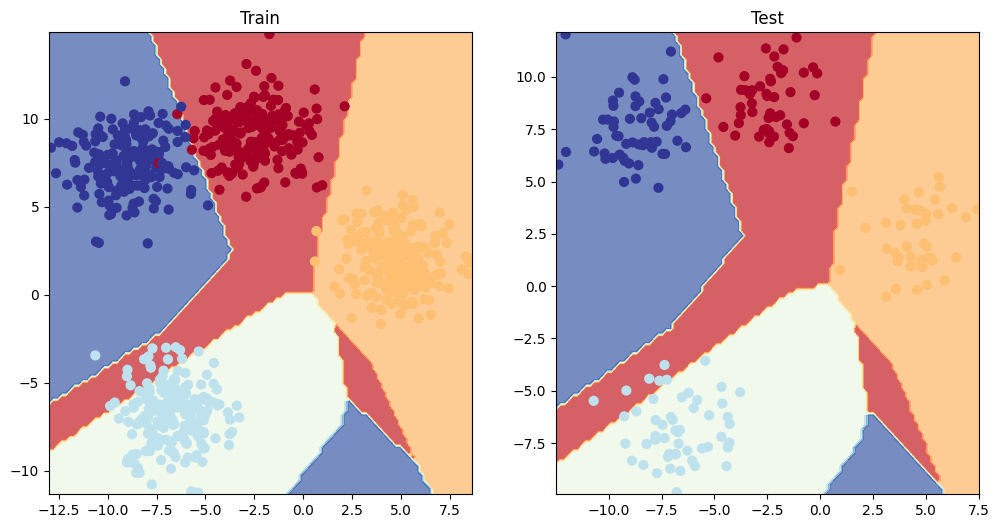

In [85]:
from helper_functions import plot_predictions, plot_decision_boundary

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_4, X_blob_train, y_blob_train)

plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_4, X_blob_test, y_blob_test)

# A few more classification metrics.. ( to evaluate our classification model)

* Accuracy - out of 100 samples, how many does our model get right?
* Precision
* Recall
* F1-Score
* Confusion Matrix
* Classification report

In [86]:
# Using troch metrics
from torchmetrics import Accuracy

# setup metric
torchmetric_accuracy = Accuracy(task="multiclass", num_classes=4).to(device)

# Calculate accuracy
torchmetric_accuracy(y_preds, y_blob_test)

tensor(0.9700, device='cuda:0')

# Exercises